# Imports

In [87]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit
from sklearn.preprocessing import *
from sklearn.decomposition import PCA
from sklearn.linear_model import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.datasets import make_regression
from sklearn.metrics import *
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from xgboost import XGBClassifier, XGBRegressor
from imblearn.datasets import make_imbalance
from category_encoders.target_encoder import TargetEncoder
import statsmodels.api as sm
import datetime as dt
import category_encoders as ce

In [88]:
start=dt.datetime.now()
print('Elapsed time: ',str(dt.datetime.now()-start))

Elapsed time:  0:00:00.000048


# Functions

In [89]:
def upsample_classes(data, target):
    
    labels = list(data[target].unique())
    i = 0
    lst = []
    while len(lst) < len(labels):
        lst.append(labels[i])
        i+=1
    
    classes = []
    for c in lst:
        classes.append(data[data[target]==c])
    
    length = 0
    class_lab = None
    for c in classes:
        if len(c)>length:
            length=len(c)
            class_lab = c
    class_lab = class_lab[target].unique()[0]
    
    a = pd.concat(classes)
    maj_class = a[a[target]==class_lab]

    lst.remove(class_lab)
    
    new_classes=[]
    for i in lst:
        new_classes.append(resample(data[data[target]==i],replace=True, n_samples=len(maj_class)))

    b = pd.concat(new_classes)
    upsample = pd.concat([a[a[target]==class_lab],b])

    return upsample

In [90]:
te = TargetEncoder()

In [91]:
def target_encoding(data, column, target):
    
    grouped = data[[column,target]].groupby(column,as_index=False).mean()
    empty_dict = {}
    for i in range(len(grouped)):
        empty_dict[grouped.iloc[i,0]]=grouped.iloc[i,1]
    data[column]=data[column].map(lambda x: empty_dict[x])
    
    return data

In [92]:
def encode_cat(df, categorical_features):
    for cat in categorical_features:
        dummy_df = df[[cat,'Target']].groupby([cat],as_index=False).mean()
        dummy_dict = {}
        for i in range(len(dummy_df)):
            dummy_dict[dummy_df.iloc[i,0]]=float(dummy_df.iloc[i,1])
        df[cat] = df[cat].map(lambda x: dummy_dict[x])

In [93]:
def classification_model(X,y,method,target,test_balance = False):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=14)
    
    train = pd.concat([X_train,y_train],axis=1)
    
    train_balanced = upsample_classes(train, target)
    
    X_train = train_balanced.drop(target, axis=1)
    y_train = train_balanced[target]
    
    if test_balance == True:
        test = pd.concat([X_test,y_test],axis=1)
        test_balanced = upsample_classes(test, len(y.unique()), target)
        X_test = test_balanced.drop(target, axis=1)
        y_test = test_balanced[target]
    
    method.fit(X_train,y_train)
    p = method.predict(X_test)
    
    print('accuracy score')
    print(f1_score(y_test, p ,average='micro'))
    print('-'*20)
    
    plt.figure(figsize=(15,8))
    sns.heatmap(confusion_matrix(y_test,p))
    plt.tight_layout()
    plt.show()

# First pipeline

In [94]:
df = pd.read_csv('df_pipe.csv')

In [95]:
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,volume,price_bin,price
0,0,0.23,Ideal,E,SI2,61.5,55.0,38.202030,0.0,326.0
1,1,0.21,Premium,E,SI1,59.8,61.0,34.505856,0.0,326.0
2,2,0.23,Good,E,VS1,56.9,65.0,38.076885,0.0,327.0
3,3,0.29,Premium,I,VS2,62.4,58.0,46.724580,0.0,334.0
4,4,0.31,Good,J,SI2,63.3,58.0,51.917250,0.0,335.0


In [67]:
dfdf = df.drop(['cut','clarity'],axis=1)

In [68]:
labs = LabelEncoder()

In [69]:
column_trans_hot = make_column_transformer(
    (OneHotEncoder(), ['color', 'cut','clarity']),
    remainder='passthrough')

column_trans_lab = make_column_transformer(
    (labs, ['color']),
    remainder='passthrough')

In [70]:
ma = MaxAbsScaler()
svm = SVC()

In [71]:
pipe_basic_hot = make_pipeline(column_trans_hot, ma, svm)
pipe_basic_lab = make_pipeline(column_trans_lab, ma, svm)

In [72]:
print(df.shape)
df.head()

(5000, 9)


,carat,cut,color,clarity,depth,table,volume,price_bin,price
16427,1.20,Good,E,SI1,59.9,64.0,189.489888,1.0,6653.0
10137,1.19,Premium,G,SI2,58.9,60.0,198.119600,0.0,4758.0
17543,1.59,Ideal,J,SI2,62.1,54.0,259.257216,1.0,7155.0
48571,0.58,Very Good,G,VVS2,62.0,57.0,94.209882,0.0,2078.0
33924,0.34,Ideal,H,IF,61.8,54.0,57.457400,0.0,863.0


In [73]:
df.drop('Unnamed: 0',axis=1,inplace=True)

KeyError: "['Unnamed: 0'] not found in axis"

In [74]:
df=df.sample(n=5000)

In [75]:
df.shape

(5000, 9)

In [80]:
X = df.drop(['price','price_bin'],axis=1)
y = df.price_bin

In [62]:
balance_df = upsample_classes(pd.concat([X,y],axis=1),'price_bin')
Xb = balance_df.drop(['price_bin'],axis=1)
yb = balance_df.price_bin

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [82]:
upsample_train = upsample_classes(pd.concat([X_train,y_train],axis=1),'price_bin')

In [83]:
pipe_basic_lab.fit(X_train,y_train)

TypeError: fit_transform() takes 2 positional arguments but 3 were given

In [65]:
p = pipe_basic_lab.predict(X_test)

AttributeError: 'ColumnTransformer' object has no attribute 'transformers_'

              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97       920
         1.0       0.79      0.82      0.81       234
         2.0       0.48      0.45      0.46        71
         3.0       0.37      0.76      0.49        25

    accuracy                           0.90      1250
   macro avg       0.66      0.75      0.68      1250
weighted avg       0.91      0.90      0.90      1250



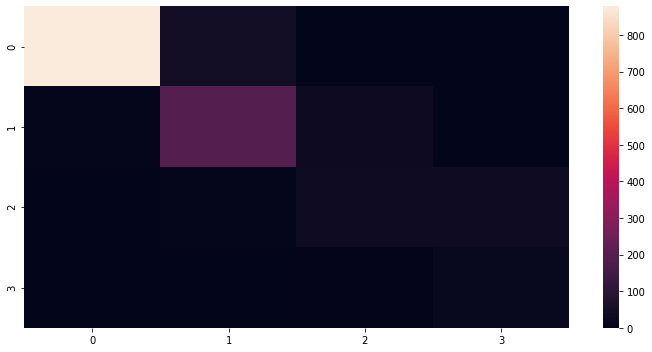

In [30]:
print(classification_report(p,y_test))

plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(p,y_test))
plt.tight_layout()
plt.show()

# Gridsearch

In [28]:
start=dt.datetime.now()

parameters = {'C': [0.1, 1, 10, 100, 1000],  'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}  

CV = GridSearchCV(svm, parameters,refit = True, verbose = 0)
CV.fit(X_train.select_dtypes(exclude='O'), y_train)   

print('Best score and parameter combination')

print(CV.best_score_)    
print(CV.best_params_) 

print('Elapsed time: ',str(dt.datetime.now()-start))

Best score and parameter combination = 
0.958053662509108
{'C': 1000, 'gamma': 1}


# Pipeline function

In [ ]:
def function():
    pass

# Second pipeline

In [31]:
df = pd.read_csv('df_pipe')

In [32]:
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,volume,price_bin,price
0,0,0.23,Ideal,E,SI2,61.5,55.0,38.202030,0.0,326.0
1,1,0.21,Premium,E,SI1,59.8,61.0,34.505856,0.0,326.0
2,2,0.23,Good,E,VS1,56.9,65.0,38.076885,0.0,327.0
3,3,0.29,Premium,I,VS2,62.4,58.0,46.724580,0.0,334.0
4,4,0.31,Good,J,SI2,63.3,58.0,51.917250,0.0,335.0


In [33]:
ma = MaxAbsScaler()
ss = StandardScaler()

In [34]:
df_num = df.select_dtypes(exclude='O').drop(['price','price_bin'],axis=1)
df_cat = df.select_dtypes(include='O')
df_tar = df[['price','price_bin']]

In [35]:
df_num=pd.DataFrame(ma.fit_transform(df_num),columns=df.select_dtypes(exclude='O').drop(['price','price_bin'],axis=1).columns)

In [36]:
df2=pd.concat([df_num,df_cat,df_tar],axis=1)

In [37]:
df.drop('Unnamed: 0',axis=1,inplace=True)
df2.drop('Unnamed: 0',axis=1,inplace=True)

In [38]:
df.head()

,carat,cut,color,clarity,depth,table,volume,price_bin,price
0,0.23,Ideal,E,SI2,61.5,55.0,38.202030,0.0,326.0
1,0.21,Premium,E,SI1,59.8,61.0,34.505856,0.0,326.0
2,0.23,Good,E,VS1,56.9,65.0,38.076885,0.0,327.0
3,0.29,Premium,I,VS2,62.4,58.0,46.724580,0.0,334.0
4,0.31,Good,J,SI2,63.3,58.0,51.917250,0.0,335.0


In [39]:
df2.head()

,carat,depth,table,volume,cut,color,clarity,price,price_bin
0,0.093878,0.922039,0.846154,0.094664,Ideal,E,SI2,326.0,0.0
1,0.085714,0.896552,0.938462,0.085505,Premium,E,SI1,326.0,0.0
2,0.093878,0.853073,1.000000,0.094354,Good,E,VS1,327.0,0.0
3,0.118367,0.935532,0.892308,0.115783,Premium,I,VS2,334.0,0.0
4,0.126531,0.949025,0.892308,0.128650,Good,J,SI2,335.0,0.0


In [40]:
for col in df.select_dtypes(include='O').columns:
    df[col]=target_encoding(df,col,'price')

In [41]:
for col in df2.select_dtypes(include='O').columns:
    df2[col]=target_encoding(df2,col,'price')

In [42]:
df2.head()

,carat,depth,table,volume,cut,color,clarity,price,price_bin
0,0.093878,0.922039,0.846154,0.094664,0.0938776,0.0938776,0.0938776,326.0,0.0
1,0.085714,0.896552,0.938462,0.085505,0.0857143,0.0857143,0.0857143,326.0,0.0
2,0.093878,0.853073,1.000000,0.094354,0.0938776,0.0938776,0.0938776,327.0,0.0
3,0.118367,0.935532,0.892308,0.115783,0.118367,0.118367,0.118367,334.0,0.0
4,0.126531,0.949025,0.892308,0.128650,0.126531,0.126531,0.126531,335.0,0.0


In [43]:
df.head()

,carat,cut,color,clarity,depth,table,volume,price_bin,price
0,0.23,0.23,0.23,0.23,61.5,55.0,38.202030,0.0,326.0
1,0.21,0.21,0.21,0.21,59.8,61.0,34.505856,0.0,326.0
2,0.23,0.23,0.23,0.23,56.9,65.0,38.076885,0.0,327.0
3,0.29,0.29,0.29,0.29,62.4,58.0,46.724580,0.0,334.0
4,0.31,0.31,0.31,0.31,63.3,58.0,51.917250,0.0,335.0


In [44]:
X=df.drop(['price','price_bin'],axis=1)
y1=df.price_bin
y2=df.price

In [45]:
logreg=LogisticRegression(random_state=14)
cross_val_score(logreg, X, y1, cv=5, scoring='accuracy').mean()

0.8298591549295775

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X,y1)

In [47]:
upsample_train = upsample_classes(pd.concat([X_train,y_train],axis=1),'price_bin')

In [48]:
X_train=upsample_train.drop('price_bin',axis=1)
y_train=upsample_train.price_bin

In [49]:
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('pca',PCA(n_components=6)), ('svc', SVC())])

In [27]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=6)),
                ('svc', SVC())])

In [28]:
p=pipe.predict(X_test)

In [29]:
print(classification_report(p,y_test))

              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93      8470
         1.0       0.80      0.55      0.65      3285
         2.0       0.76      0.44      0.55      1558
         3.0       0.00      0.00      0.00         0

    accuracy                           0.82     13313
   macro avg       0.61      0.49      0.53     13313
weighted avg       0.84      0.82      0.82     13313



# Pipeline with Gridsearch

In [ ]:
pipe = Pipeline([('scl', MinMaxScaler()),
                ('pca', PCA(n_components=7)),
                ('svm', SVC(random_state=14))])

grid = [{'svm__kernel': ['poly', 'sigmoid'],
         'svm__C': [0.01, 1, 100],
         'svm__degree': [2,3,4,5],
         'svm__gamma': [0.001, 0.01]}]

gridsearch = GridSearchCV(estimator=pipe,
                  param_grid=grid,
                  scoring='accuracy',
                  cv=3)

gridsearch.fit(X_train, y_train)